In [1]:
# ruff: noqa: F401

In [2]:
%load_ext autoreload
%load_ext pyinstrument

%autoreload 2

In [3]:
import sys

sys.path.insert(0, "..")

In [4]:
from datetime import datetime, timedelta
from pathlib import Path

import hvplot.polars
import numpy as np
import polars as pl

In [5]:
from tsdb_benchmarks.monetdb import MonetDB
from tsdb_benchmarks.monetdb.fetch import fetch_binary, fetch_pymonetdb

db = MonetDB()

In [8]:
fetch_binary("select * from test", db.connect())

id,val,time,on_off,dbl,some_int
i32,f32,datetime[ms],bool,f64,i32
1,1.0,null,null,null,null
2,null,null,null,null,null
3,2.0,null,null,null,2
22,null,2025-05-02 12:00:00,null,null,null
222,null,null,true,null,null
223,null,null,false,null,null


In [9]:
fetch_pymonetdb("select * from test", db.connect())

id,val,time,on_off,dbl,some_int
i32,f32,datetime[ms],bool,f64,i32
1,1.0,null,null,null,null
2,null,null,null,null,null
3,2.0,null,null,null,2
22,null,2025-05-02 12:00:00,null,null,null
222,null,null,true,null,null
223,null,null,false,null,null


In [10]:
from time import perf_counter

data = {"limit": [], "binary": [], "pymonetdb": []}

for limit in [1, 10, 100, 1_000, 5_000, 10_000, 50_000, 100_000, 500_000, 1_000_000, 5_000_000] + [
    n * 10_000_000 for n in range(1, 11)
]:
    q = f"select id, value from large order by id limit {limit}"

    t0 = perf_counter()

    fetch_pymonetdb(q, db.connect())

    data["pymonetdb"].append(perf_counter() - t0)

    t0 = perf_counter()

    fetch_binary(q, db.connect())

    data["binary"].append(perf_counter() - t0)

    data["limit"].append(limit)

    print(f"Fetched with limit {limit:_}")

Fetched with limit 1
Fetched with limit 10
Fetched with limit 100
Fetched with limit 1_000
Fetched with limit 5_000
Fetched with limit 10_000
Fetched with limit 50_000
Fetched with limit 100_000
Fetched with limit 500_000
Fetched with limit 1_000_000
Fetched with limit 5_000_000
Fetched with limit 10_000_000
Fetched with limit 20_000_000
Fetched with limit 30_000_000
Fetched with limit 40_000_000
Fetched with limit 50_000_000
Fetched with limit 60_000_000
Fetched with limit 70_000_000
Fetched with limit 80_000_000
Fetched with limit 90_000_000
Fetched with limit 100_000_000


In [11]:
pl.DataFrame(data).hvplot(x="limit", kind="scatter", grid=True)

:NdOverlay   [Variable]
   :Scatter   [limit]   (value)

id,value,ts
i32,f64,datetime[ms]
1,2.0,2025-01-01 00:00:00
2,4.0,2025-01-01 00:00:00
3,6.0,2025-01-01 00:00:00
4,8.0,2025-01-01 00:00:00
5,10.0,2025-01-01 00:00:00
…,…,…
9999996,1.9999992e7,2025-01-01 00:00:00
9999997,1.9999994e7,2025-01-01 00:00:00
9999998,1.9999996e7,2025-01-01 00:00:00


_     ._   __/__   _ _  _  _ _/_   Recorded: 18:04:37  Samples:  9907
 /_//_/// /_\ / //_// / //_'/ //     Duration: 12.874    CPU time: 12.705
/   _/                      v5.0.2

Cell [12]

12.874 <module>  /var/folders/wt/2s8cn3zn1nndhbq08y2cjm500000gn/T/ipykernel_39913/1535413955.py:1
`- 12.862 fetch_pymonetdb  tsdb_benchmarks/monetdb/fetch.py:47
   |- 10.590 Cursor.fetchall  pymonetdb/sql/cursors.py:330
   |     [16 frames hidden]  pymonetdb, <built-in>
   |        8.995 TimestampDecoder.decode  pymonetdb/sql/pythonizebin.py:172
   |        `- 6.937 [self]  pymonetdb/sql/pythonizebin.py
   `- 2.251 DataFrame.__init__  polars/dataframe/frame.py:359
         [5 frames hidden]  polars, functools, <built-in>
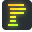

In [12]:
%%pyinstrument

fetch_pymonetdb("select id, value, ts from large limit 10000000", db.connect())

id,value,ts
i32,f64,datetime[ms]
1,2.0,2025-01-01 00:00:00
2,4.0,2025-01-01 00:00:00
3,6.0,2025-01-01 00:00:00
4,8.0,2025-01-01 00:00:00
5,10.0,2025-01-01 00:00:00
…,…,…
9999996,1.9999992e7,2025-01-01 00:00:00
9999997,1.9999994e7,2025-01-01 00:00:00
9999998,1.9999996e7,2025-01-01 00:00:00


_     ._   __/__   _ _  _  _ _/_   Recorded: 18:04:58  Samples:  322
 /_//_/// /_\ / //_// / //_'/ //     Duration: 0.642     CPU time: 0.565
/   _/                      v5.0.2

Cell [13]

0.641 <module>  /var/folders/wt/2s8cn3zn1nndhbq08y2cjm500000gn/T/ipykernel_39913/2872338409.py:1
`- 0.641 fetch_binary  tsdb_benchmarks/monetdb/fetch.py:166
   |- 0.337 Connection.execute  pymonetdb/sql/connections.py:213
   |     [15 frames hidden]  pymonetdb, shutil, <built-in>
   |        0.143 socket.recv_into  <built-in>
   `- 0.297 read_column_bin  tsdb_benchmarks/monetdb/fetch.py:109
      |- 0.262 read_timestamp_column  tsdb_benchmarks/monetdb/fetch.py:66
      |  |- 0.227 DataFrame.select  polars/dataframe/frame.py:9728
      |  |     [3 frames hidden]  polars
      |  |        0.227 PyLazyFrame.collect  <built-in>
      |  |- 0.019 DataFrame.__init__  polars/dataframe/frame.py:359
      |  |     [5 frames hidden]  polars, <built-in>
      |  `- 0.011 BufferedReader.read  <built-in>
      |- 0.021 Series.wrapper  polars/series/utils.py:99
      |     [5 frames hidden]  polars, <built-in>
      `- 0.012 BufferedReader.read  <built-in>
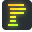

In [13]:
%%pyinstrument

fetch_binary("select id, value, ts from large limit 10000000", db.connect())